## opcode, register 빈도수로 학습

In [1]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import glob
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
train_benign_df = pd.read_csv("./csv_files/train_benign_asmfile.txt")
train_benign_df.drop(train_benign_df.columns[-1], axis=1, inplace=True)
train_benign_df.set_axis(['ID', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword'], axis='columns', inplace=True)
train_benign_df['label'] = 0

train_malware_df = pd.read_csv("./csv_files/train_malware_asmfile.txt")
train_malware_df.drop(train_malware_df.columns[-1], axis=1, inplace=True)
train_malware_df.set_axis(['ID', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword'], axis='columns', inplace=True)
train_malware_df['label'] = 1

test_benign_df = pd.read_csv("./csv_files/test_benign_asmfile.txt")
test_benign_df.drop(test_benign_df.columns[-1], axis=1, inplace=True)
test_benign_df.set_axis(['ID', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword'], axis='columns', inplace=True)
test_benign_df['label'] = 0

test_malware_df = pd.read_csv("./csv_files/test_malware_asmfile.txt")
test_malware_df.drop(test_malware_df.columns[-1], axis=1, inplace=True)
test_malware_df.set_axis(['ID', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword'], axis='columns', inplace=True)
test_malware_df['label'] = 1

valid_benign = pd.read_csv("./csv_files/valid_benign_asmfile.txt")
valid_benign.drop(valid_benign.columns[-1], axis=1, inplace=True)
valid_benign.set_axis(['ID', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword'], axis='columns', inplace=True)
valid_benign['label'] = 0

valid_malware = pd.read_csv("./csv_files/valid_malware_asmfile.txt")
valid_malware.drop(valid_malware.columns[-1], axis=1, inplace=True)
valid_malware.set_axis(['ID', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword'], axis='columns', inplace=True)
valid_malware['label'] = 1


In [3]:
import sklearn
df_list = [train_benign_df, train_malware_df, test_benign_df, test_malware_df, valid_benign, valid_malware]
full_df = pd.concat(df_list, ignore_index=True, axis=0)
full_df

,ID,jmp,mov,retf,push,pop,xor,retn,nop,sub,...,ebx,ecx,edi,ebp,esp,eip,.dll,std::,:dword,label
0,4d1bbe1ef6371b338826836d740d726f,2473,25391,0,11703,3486,2544,1724,25,1304,...,0,0,0,0,0,0,2,367,113,0
1,0d2b28bec8d17f692db56e87cce59992,520,4692,0,5653,1239,453,520,0,274,...,0,0,0,1,1,0,7,0,17,0
2,4df4d08911a65aa83284545ca1ffeb71,294,2016,0,2579,711,348,271,6,165,...,0,0,0,0,0,0,7,0,7,0
3,1ed70ce407ad8203816829b4ea1aae3d,289,1306,0,1992,170,127,77,0,88,...,0,0,0,0,0,0,0,0,0,0
4,2eccffbe627068a60bf7911fd8701ae6,143,1165,0,1107,266,124,159,0,48,...,0,0,0,0,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2789,4b5bb563356dc66b6fa4b6ce1e97e19a,43,689,0,1304,323,110,113,24,52,...,0,0,0,0,0,0,6,0,0,1
2790,4e1e3078cab979e151f372dc89b8cab6,397,2246,0,2725,497,401,177,0,172,...,0,0,0,1,0,0,9,0,1,1
2791,4dbe480956c97011f3d217ee4db18ede,33,672,0,145,81,164,79,1,107,...,0,0,0,0,0,0,0,4,5,1
2792,4caedb9cd210391b7fc7c234562af9cb,36,719,0,690,138,112,65,0,43,...,0,0,0,0,0,0,0,0,0,1


### 정규화

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
NORMALIZE_VALID_COLUMNS = [ 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword']

full_df[NORMALIZE_VALID_COLUMNS] = scaler.fit_transform(full_df[NORMALIZE_VALID_COLUMNS])
full_df[NORMALIZE_VALID_COLUMNS].astype('float')

,jmp,mov,retf,push,pop,xor,retn,nop,sub,inc,...,eax,ebx,ecx,edi,ebp,esp,eip,.dll,std::,:dword
0,0.023719,0.015745,0.000000,0.019343,0.015207,0.016294,0.020123,0.001079,0.011718,0.004959,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.005917,0.017681,0.003829
1,0.004987,0.002902,0.000000,0.009343,0.005405,0.002901,0.006070,0.000000,0.002462,0.002922,...,0.0,0.0,0.0,0.0,0.006944,0.010204,0.0,0.020710,0.000000,0.000576
2,0.002820,0.001242,0.000000,0.004263,0.003102,0.002229,0.003163,0.000259,0.001483,0.001264,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.020710,0.000000,0.000237
3,0.002772,0.000801,0.000000,0.003292,0.000742,0.000813,0.000899,0.000000,0.000791,0.001644,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,0.001372,0.000714,0.000000,0.001830,0.001160,0.000794,0.001856,0.000000,0.000431,0.000646,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.005917,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2789,0.000412,0.000418,0.000000,0.002155,0.001409,0.000705,0.001319,0.001036,0.000467,0.001278,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.017751,0.000000,0.000000
2790,0.003808,0.001384,0.000000,0.004504,0.002168,0.002568,0.002066,0.000000,0.001546,0.003203,...,0.0,0.0,0.0,0.0,0.006944,0.000000,0.0,0.026627,0.000000,0.000034
2791,0.000317,0.000408,0.000000,0.000240,0.000353,0.001050,0.000922,0.000043,0.000962,0.000112,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000193,0.000169
2792,0.000345,0.000437,0.000000,0.001140,0.000602,0.000717,0.000759,0.000000,0.000386,0.000843,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


### train_test_split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(full_df[NORMALIZE_VALID_COLUMNS],full_df['label'], stratify=full_df['label'], test_size=0.2, random_state=42)

###  label값 개수를 동일하게 하기 위한 교차검증 사용 (stratifiedKFold)

#### DecisionTree Classifier

### 주성분검출(PCA)

In [6]:
from sklearn.decomposition import PCA

skpca = PCA(n_components=30)
X_pca = skpca.fit_transform(X_train)
print('Variance sum : ', skpca.explained_variance_ratio_.cumsum()[-1])

Variance sum :  0.9989883935856708


In [7]:
features = full_df[NORMALIZE_VALID_COLUMNS]
label = full_df['label']

### RandomForestClassifier

In [8]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import classification_report, confusion_matrix

model = RFC(n_estimators=100, random_state=0, 
                          oob_score = True,
                          max_depth = 16, 
                          max_features = 'sqrt')

model.fit(X_pca, y_train)

X_test_scaled = scaler.transform(X_test)
X_test_new = pd.DataFrame(X_test_scaled, columns=features.columns)
X_test_pca = skpca.transform(X_test_new)

y_pred = model.predict(X_test_pca)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.05      0.10       280
           1       0.51      0.99      0.67       279

    accuracy                           0.52       559
   macro avg       0.65      0.52      0.39       559
weighted avg       0.65      0.52      0.39       559



<AxesSubplot:>

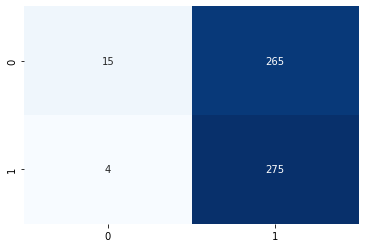

In [9]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False)

### Support Vector Machine

In [10]:
from sklearn.svm import SVC

In [11]:
model = SVC()

In [12]:
model.fit(X_pca,y_train)

SVC()

In [13]:
predictions = model.predict(X_test_pca)

In [14]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       280
           1       0.50      1.00      0.67       279

    accuracy                           0.50       559
   macro avg       0.25      0.50      0.33       559
weighted avg       0.25      0.50      0.33       559



<AxesSubplot:>

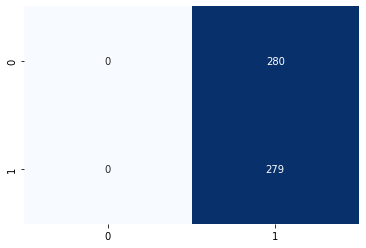

In [15]:
sns.heatmap(confusion_matrix(y_test,predictions), annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False)

### 하이퍼 파라미터 search (GridSearchCV)

In [16]:
from sklearn.model_selection import GridSearchCV

In [18]:
params = { 'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 100, 200],
           'max_depth' : [12, 14, 16, 18, 20, 22, 24],
           'min_samples_leaf' : [2, 3, 4, 5, 6],
           'min_samples_split' : [1, 2, 3, 4, 5, 6]
            }

In [19]:
hipher_rf_clf = RandomForestClassifier(random_state=0, n_jobs = -1, max_features = 'sqrt')
grid_cv = GridSearchCV(hipher_rf_clf, params, cv = 5, n_jobs=-1)
grid_cv.fit(X_pca, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도 : {:.4f}'.format(grid_cv.best_score_))


최적 하이퍼 파라미터:  {'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 40}
최고 예측 정확도 : 0.9199


In [23]:
rf_best = RandomForestClassifier(n_estimators=40,
                                 max_depth=18,
                                 min_samples_leaf=2,
                                 min_samples_split=5,
                                 random_state=0,
                                 n_jobs=-1)
rf_best.fit(X_pca, y_train)

pred = rf_best.predict(X_test_pca)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.51      0.96      0.67       280
           1       0.68      0.08      0.15       279

    accuracy                           0.52       559
   macro avg       0.59      0.52      0.41       559
weighted avg       0.59      0.52      0.41       559



PCA하면 오히려 성능 낮아짐 사용 안하겠음